# Carga de librerías y módulos

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import re
import psycopg2
import warnings
import os
from glob import glob
import geopandas as gpd
import numpy as np
from shapely import wkt
from shapely.geometry import Point
from pathlib import Path
from PIL import Image
from collections import Counter
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm

warnings.filterwarnings(action='ignore', category=FutureWarning, 
                        message=r".*Use a DatetimeIndex.*")

warnings.filterwarnings(action='ignore', category=UserWarning)
pd.options.mode.copy_on_write = True


# Carga de datos

Cada fichero ZIP contiene un número determinado de fotografías además de 1 fichero CSV con los metadatos de cada fotografía. Este ZIP y el CSV son generados automáticamente por la [app de móvil Solocator](https://solocator.com/).

In [2]:
path = '/media/joan_ds/Seagate Portable Drive/dades/Solocator'
lst_csv = []

for zips in glob('/'.join([path, '*.zip'])):
    with ZipFile(zips) as zp:
        files = zp.namelist()
        filecounts = {}
        for file in files:
            ext = file.split('.')[-1]
            if ext in filecounts:
                filecounts[ext] += 1
            else:
                filecounts[ext] = 1
            
            if ext == 'csv':
                with zp.open(file) as f:
                    # https://stackoverflow.com/a/17978188
                    df = pd.read_csv(f, parse_dates=[['Date', 'Time']], date_format="mixed", dayfirst=True)
                    df['filename_zip'] = zp.filename.rsplit("/")[-1]
                    lst_csv.append(df)


        print(zp.filename,'\t\t',', '.join([' '.join(map(str,elem)) for elem in filecounts.items()]))

print(f"\nContamos {len(lst_csv)} ficheros CSV.")

/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_17.zip 		 jpg 56, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_01.zip 		 jpg 90, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_02.zip 		 jpg 124, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_03.zip 		 jpg 64, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_04.zip 		 jpg 78, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_05.zip 		 jpg 73, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_06.zip 		 jpg 119, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_07.zip 		 jpg 36, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_08.zip 		 jpg 80, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_09.zip 		 jpg 49, csv 1
/media/joan_ds/Seagate Portable Drive/dades/Solocator/Solocator_10.zip 		 jpg 96, csv 1
/media/joan_ds/Seagate Portabl

In [3]:
df = pd.concat(lst_csv)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3302 entries, 0 to 85
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll                  330

In [4]:
df.head()

Date_Time                                    Photo file Name  \
0 2024-10-19 09:17:50  2024-10-19-09-17-50-Pg. Vall d'Hebron 101.X-Pg...   
1 2024-10-19 09:18:24  2024-10-19-09-18-24-Pg. Vall d'Hebron 101.X 02...   
2 2024-10-19 09:18:38  2024-10-19-09-18-38-Pg. Vall d'Hebron 101.X 03...   
3 2024-10-19 09:19:33  2024-10-19-09-19-33-Pg. Vall d'Hebron 101.X 04...   
4 2024-10-19 09:20:07  2024-10-19-09-20-07-Pg. Vall d'Hebron 101.X 05...   

   Direction   Latitude  Longitude Position Accuracy Altitude   Datum  \
0        231  41.424361   2.141726               ±0m      0 m  WGS-84   
1         15  41.424361   2.141726               ±0m      0 m  WGS-84   
2        335  41.424361   2.141726               ±0m      0 m  WGS-84   
3         32  41.424330   2.141709               ±0m      0 m  WGS-84   
4        159  41.424476   2.141786               ±0m      0 m  WGS-84   

                                Capture Mode Details Project Name  \
0  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN   
1  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN   
2  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN   
3  Street Address: Pg Vall d'Hebron - Av Jordà, H...          NaN   
4  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN   

            Photo Description  Watermark    Tilt  Roll      filename_zip  
0     Pg. Vall d'Hebron 101.X        NaN  -26.2°  3.1°  Solocator_17.zip  
1  Pg. Vall d'Hebron 101.X 02        NaN  -28.7°  5.1°  Solocator_17.zip  
2  Pg. Vall d'Hebron 101.X 03        NaN  -21.0°  0.9°  Solocator_17.zip  
3  Pg. Vall d'Hebron 101.X 04        NaN  -27.4°  0.2°  Solocator_17.zip  
4  Pg. Vall d'Hebron 101.X 05        NaN  -24.1°  6.5°  Solocator_17.zip

In [5]:
df['year'] = df.Date_Time.dt.year.astype(int)
df['month_name'] = df.Date_Time.dt.month_name()
df['month_number'] = df.Date_Time.dt.month
df['quarter'] = df.Date_Time.dt.quarter
df['day'] = df.Date_Time.dt.day
df['day_week'] = df.Date_Time.dt.dayofweek
df['day_week_name'] = df.Date_Time.dt.day_name()
isocalendar = df.Date_Time.dt.isocalendar()
df['week'] = isocalendar['week'].astype(int)
df['hour'] = df.Date_Time.dt.hour
df['minute'] = df.Date_Time.dt.minute

df.head()

Date_Time                                    Photo file Name  \
0 2024-10-19 09:17:50  2024-10-19-09-17-50-Pg. Vall d'Hebron 101.X-Pg...   
1 2024-10-19 09:18:24  2024-10-19-09-18-24-Pg. Vall d'Hebron 101.X 02...   
2 2024-10-19 09:18:38  2024-10-19-09-18-38-Pg. Vall d'Hebron 101.X 03...   
3 2024-10-19 09:19:33  2024-10-19-09-19-33-Pg. Vall d'Hebron 101.X 04...   
4 2024-10-19 09:20:07  2024-10-19-09-20-07-Pg. Vall d'Hebron 101.X 05...   

   Direction   Latitude  Longitude Position Accuracy Altitude   Datum  \
0        231  41.424361   2.141726               ±0m      0 m  WGS-84   
1         15  41.424361   2.141726               ±0m      0 m  WGS-84   
2        335  41.424361   2.141726               ±0m      0 m  WGS-84   
3         32  41.424330   2.141709               ±0m      0 m  WGS-84   
4        159  41.424476   2.141786               ±0m      0 m  WGS-84   

                                Capture Mode Details Project Name  ...  year  \
0  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN  ...  2024   
1  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN  ...  2024   
2  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN  ...  2024   
3  Street Address: Pg Vall d'Hebron - Av Jordà, H...          NaN  ...  2024   
4  Street Address: Pg. de la Vall d'Hebron, 101X,...          NaN  ...  2024   

   month_name month_number quarter day  day_week day_week_name  week  hour  \
0     October           10       4  19         5      Saturday    42     9   
1     October           10       4  19         5      Saturday    42     9   
2     October           10       4  19         5      Saturday    42     9   
3     October           10       4  19         5      Saturday    42     9   
4     October           10       4  19         5      Saturday    42     9   

   minute  
0      17  
1      18  
2      18  
3      19  
4      20  

[5 rows x 25 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3302 entries, 0 to 85
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll                  330

# Distribución de los datos de la marca temporal

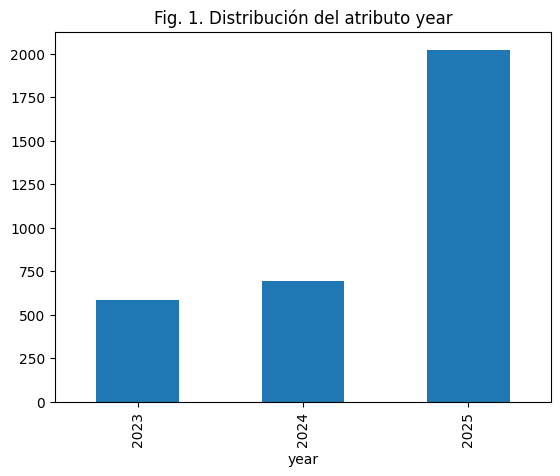

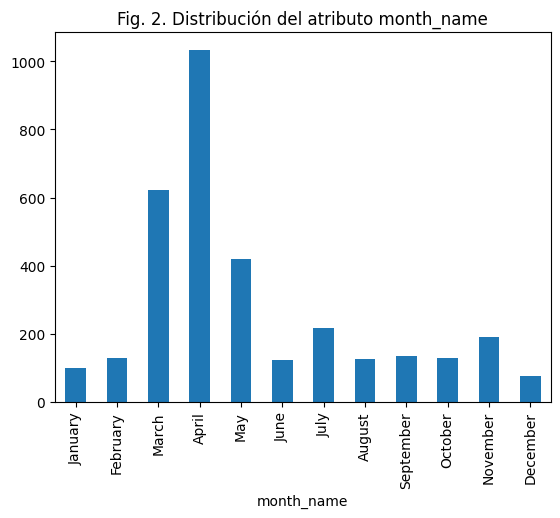

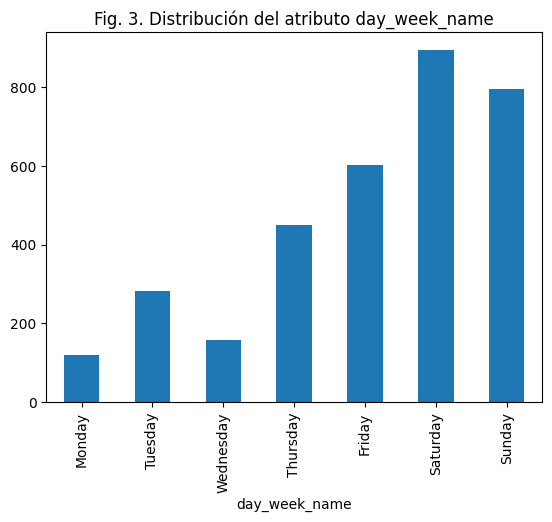

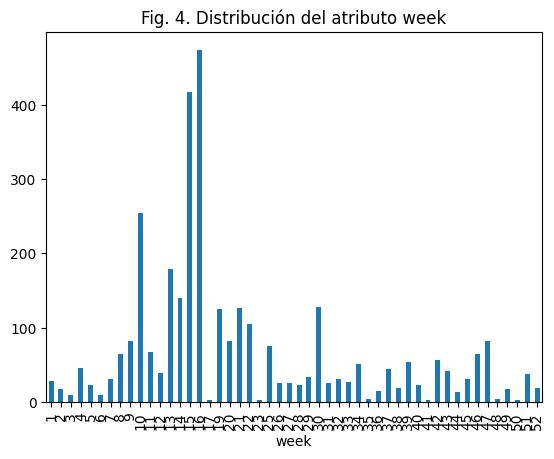

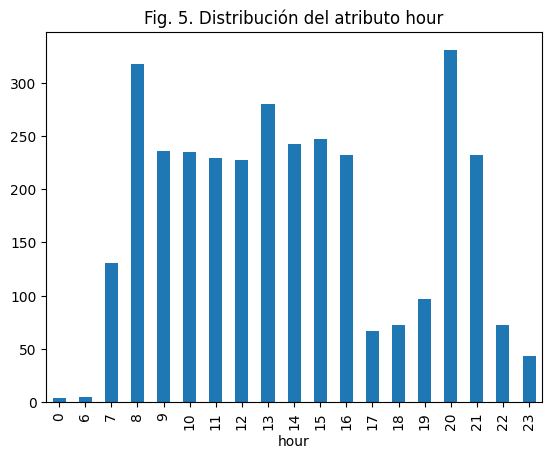

In [7]:
years = [2023, 2024, 2025]

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

day_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weeks = list(set(df.week))

hours = list(set(df.hour))

dicc_cols_lst = [{'name': 'year', 'labels': years}, {'name': 'month_name', 'labels': months},
                  {'name': 'day_week_name', 'labels': day_week_names}, {'name': 'week', 'labels': weeks},
                  {'name': 'hour', 'labels': hours}]

count_fig = 0

for dicc in dicc_cols_lst:
    name = dicc['name']
    labels = dicc['labels']

    df[name].value_counts()[labels].plot.bar(x=name)

    count_fig +=1
    plt.title(f"Fig. {count_fig}. Distribución del atributo {name}")

    plt.show()


In [8]:
quarters = list(set(df.quarter))
dicc_quaters = {'name': 'quarter', 'labels': quarters}

dicc_cols_lst.append(dicc_quaters)

mask_names = ['year', 'quarter']

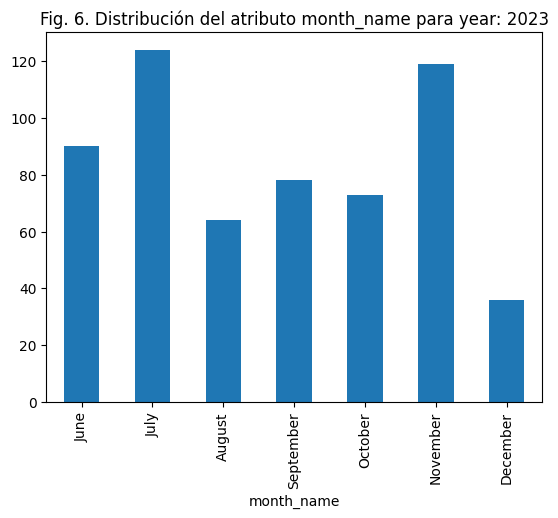

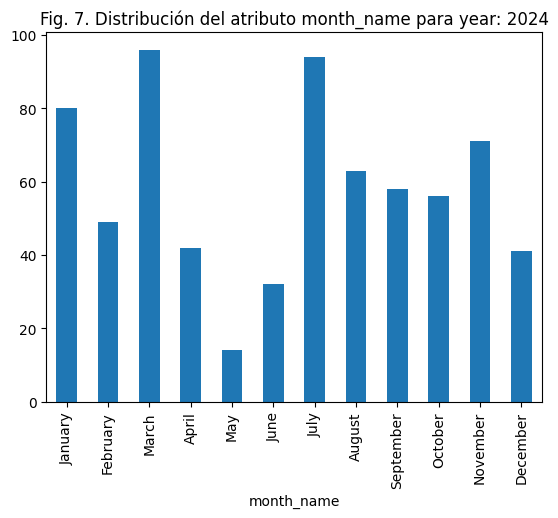

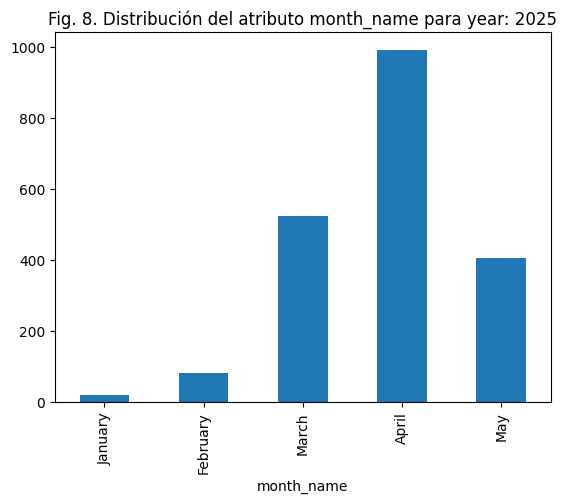

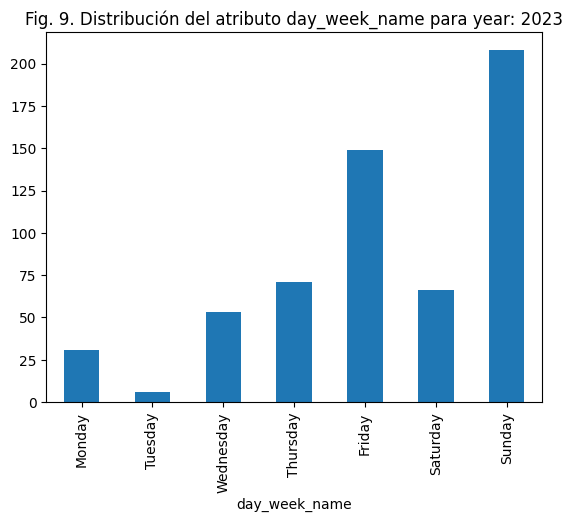

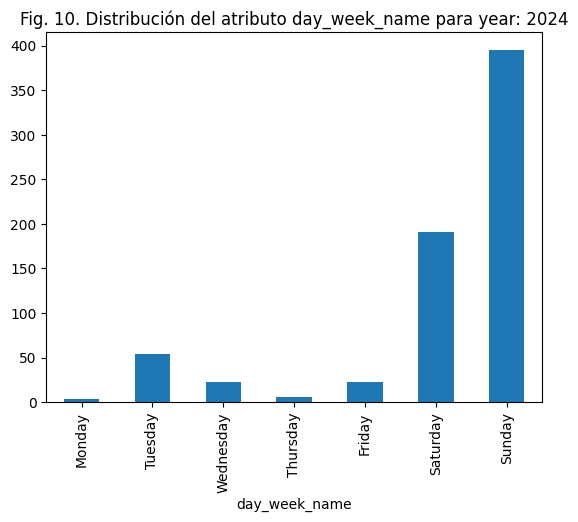

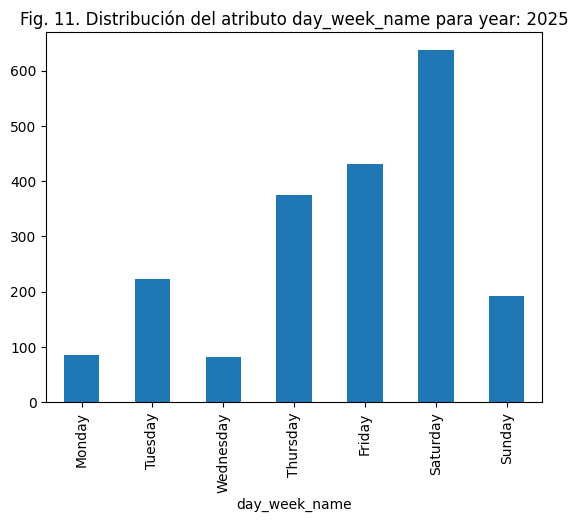

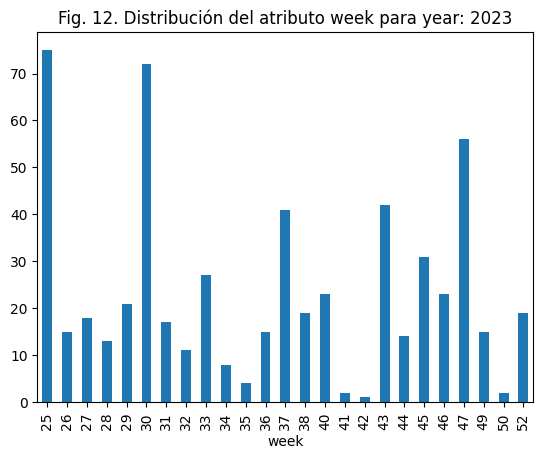

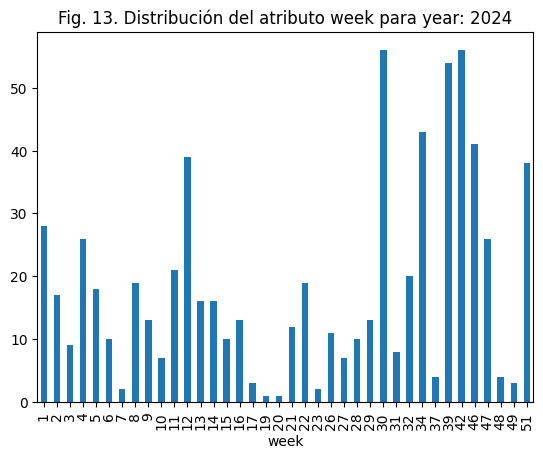

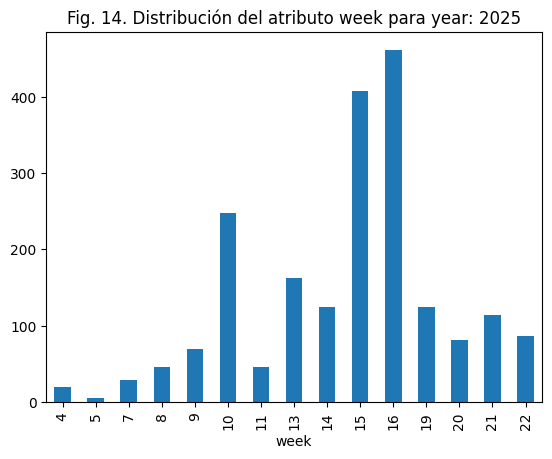

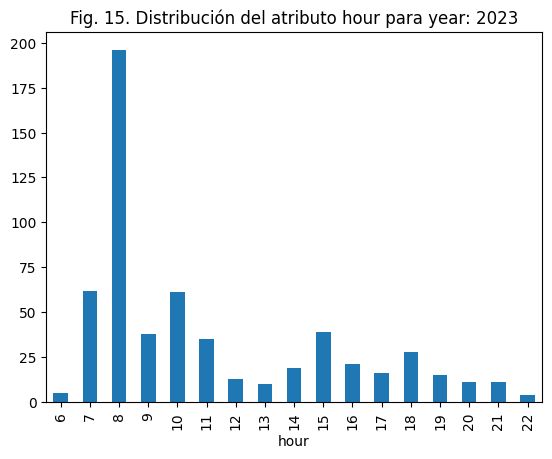

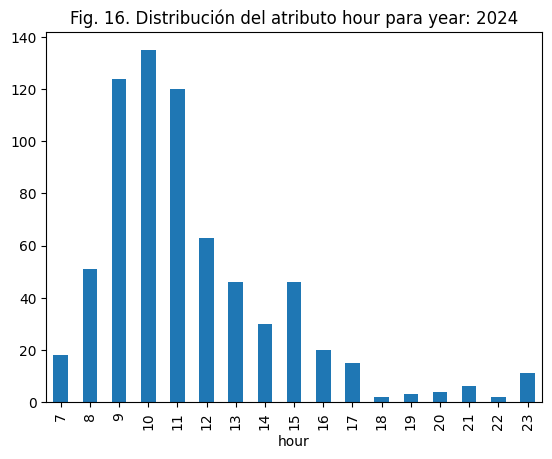

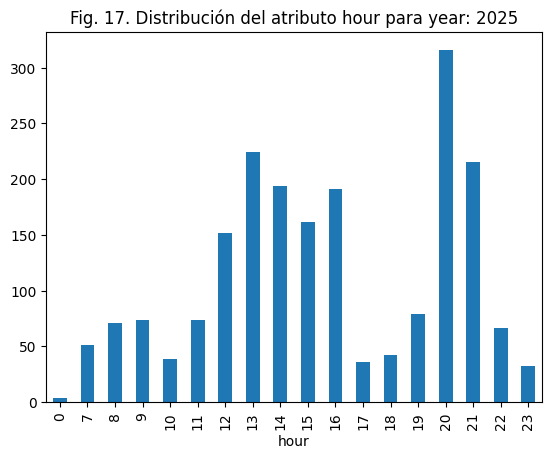

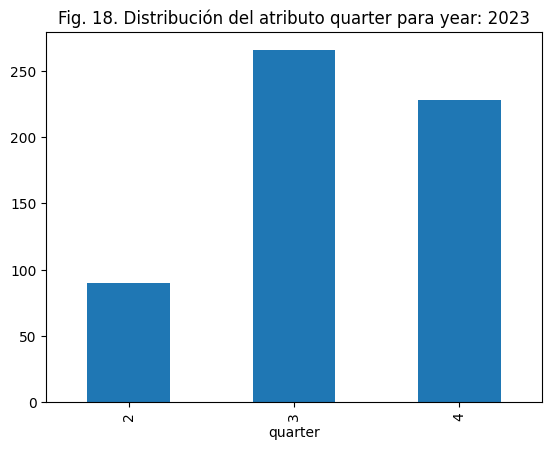

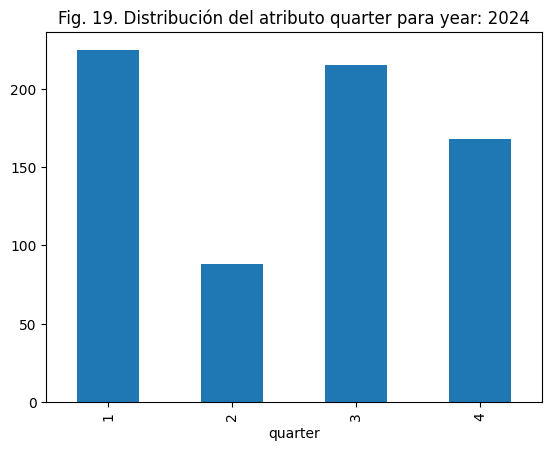

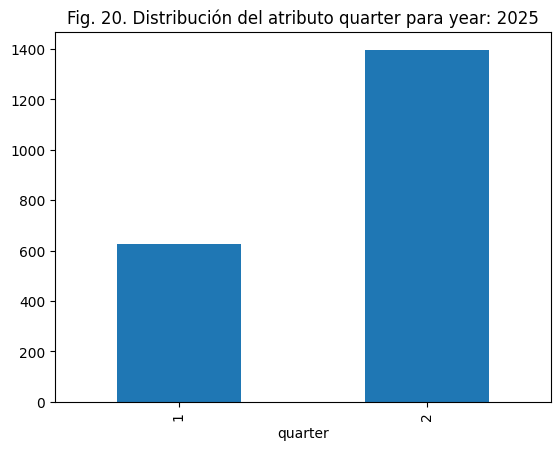

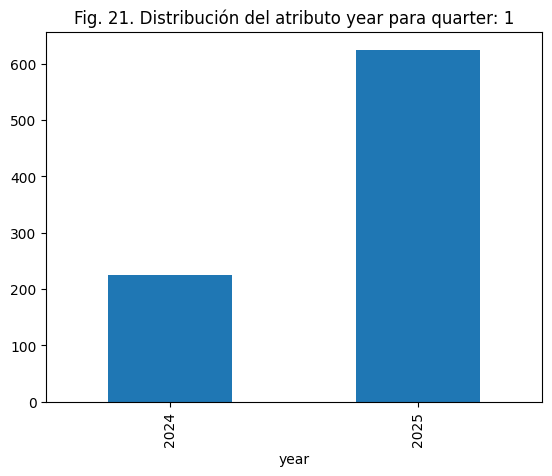

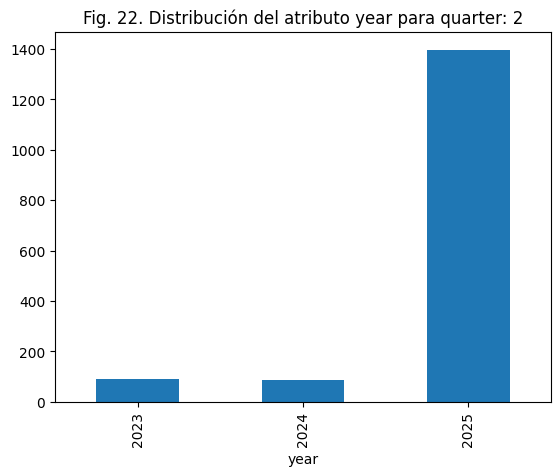

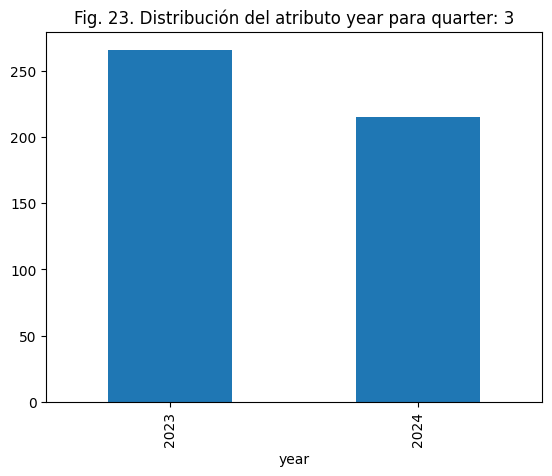

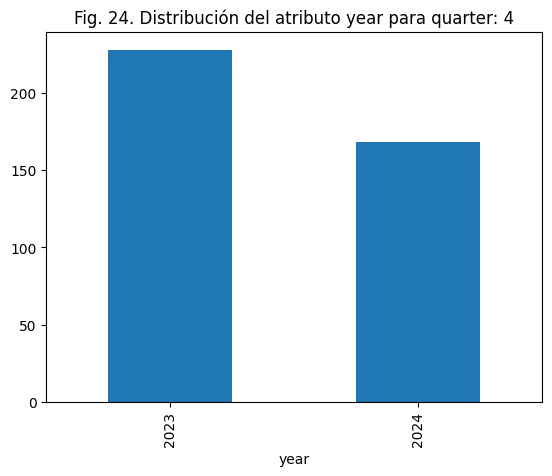

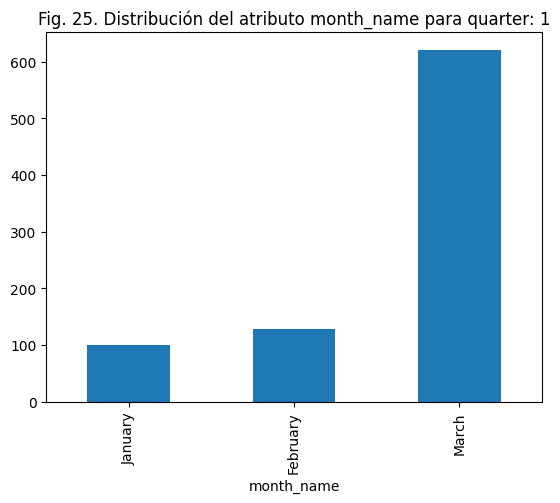

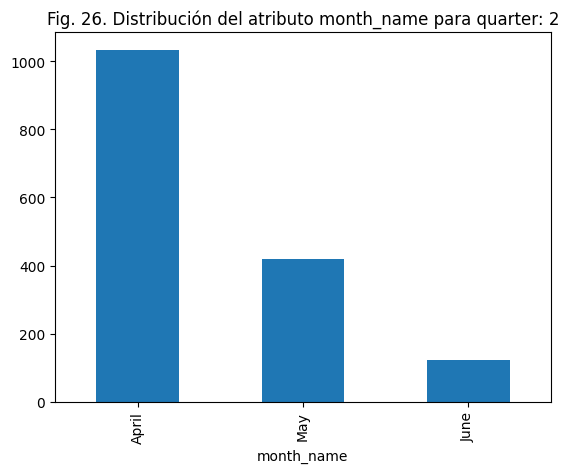

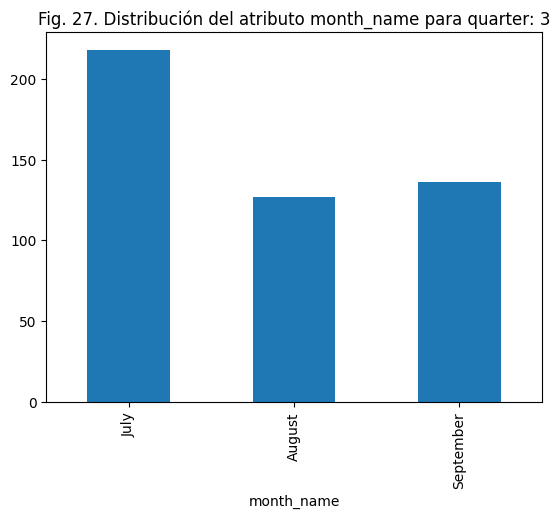

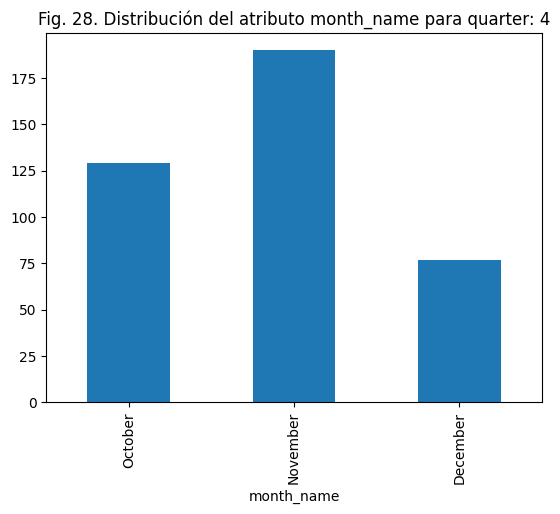

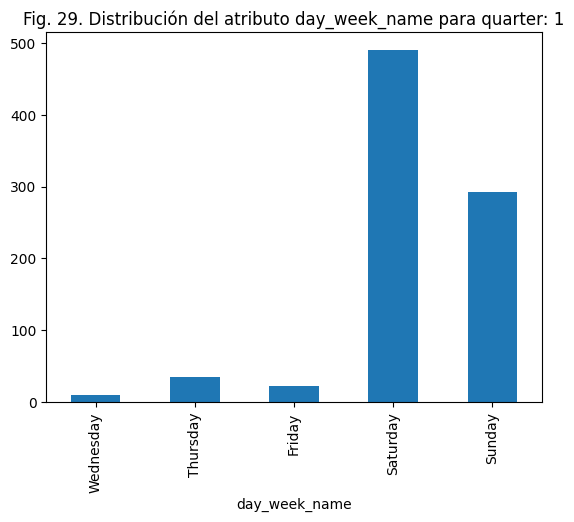

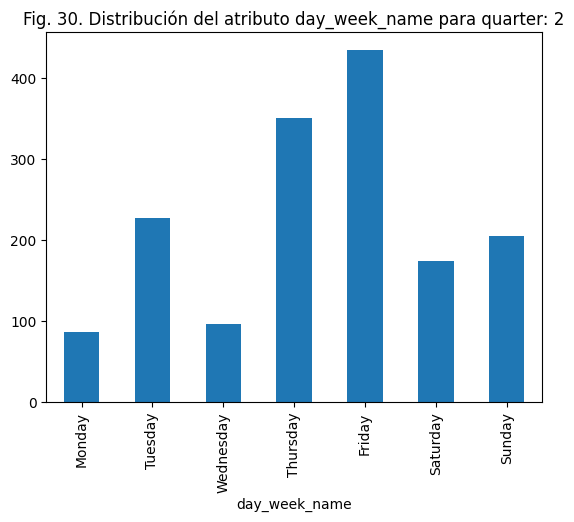

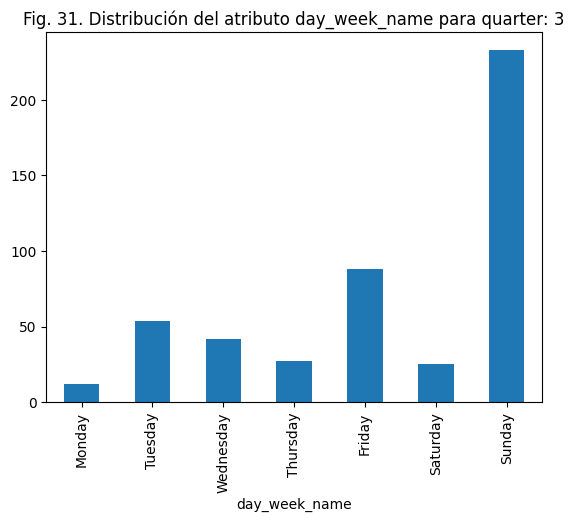

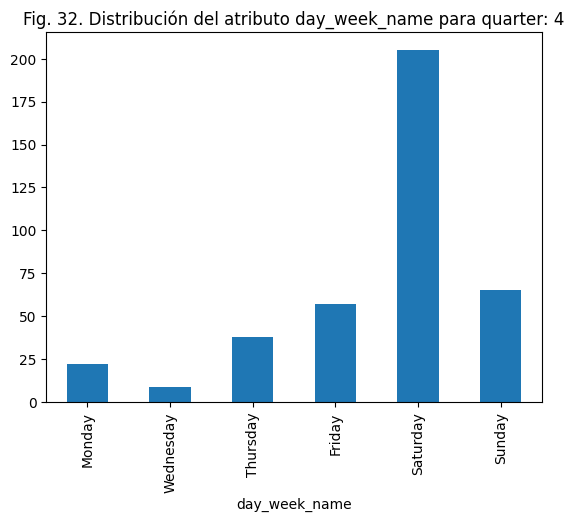

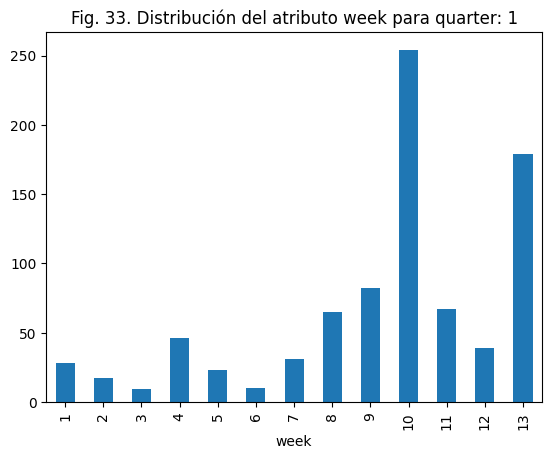

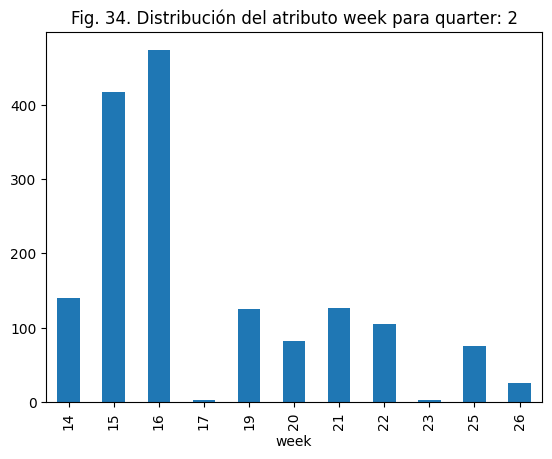

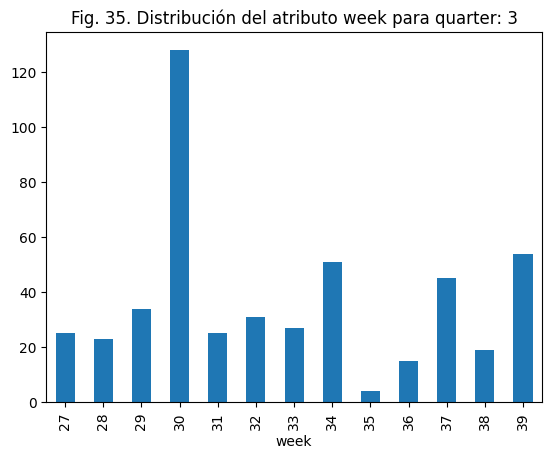

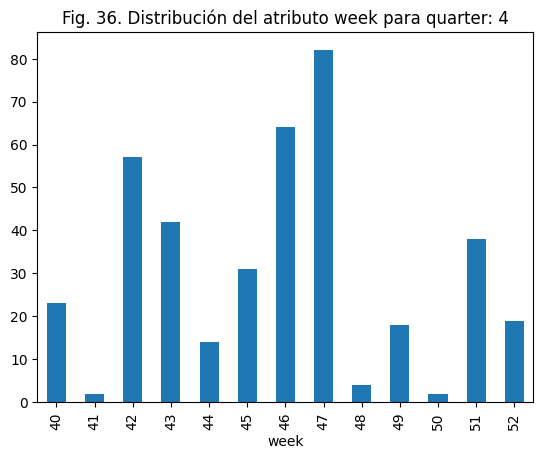

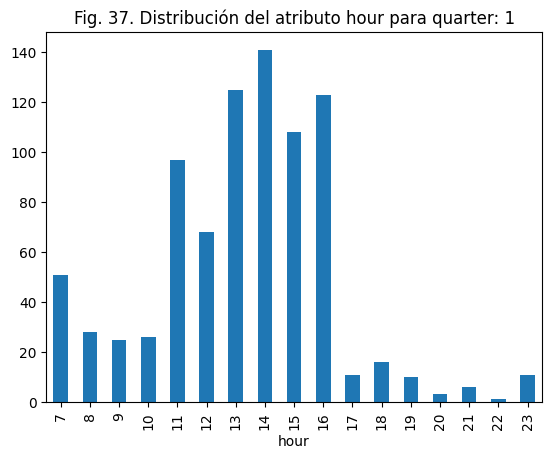

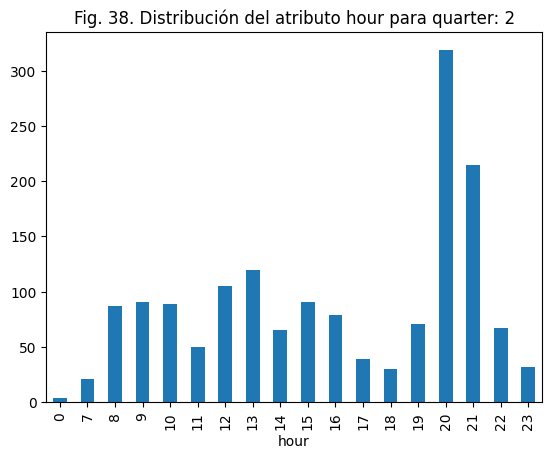

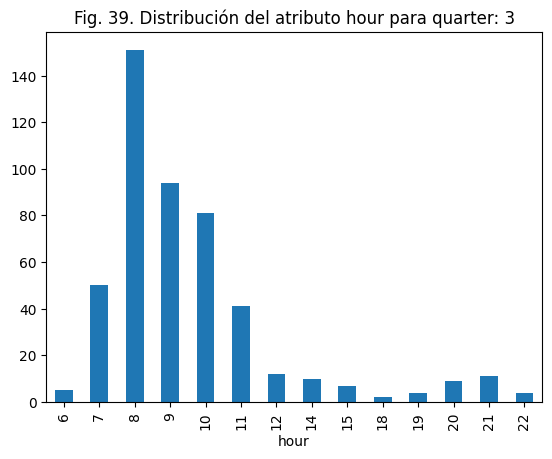

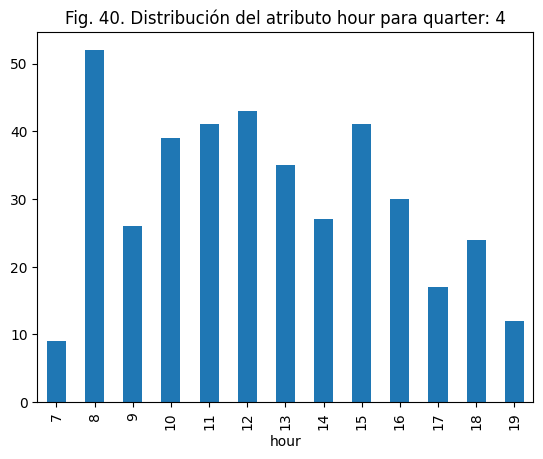

In [9]:
for mask_name in mask_names:

    for dicc in dicc_cols_lst:
        name = dicc['name']

        if mask_name != name:
            classes_lst = list(set(df[mask_name]))

            if type(classes_lst[0]) == int:
                classes_lst.sort()

            for class_ in classes_lst:
                mask = df[mask_name] == class_
                df_ = df[mask]
            
                labels = dicc['labels']
                labels_ = list(set(df_[name]))

                labels_result = [l for l in labels if l in labels_]

                df_[name].value_counts()[labels_result].plot.bar(x=name)

                count_fig +=1
                plt.title(f"Fig. {count_fig}. Distribución del atributo {name} para {mask_name}: {class_}")

                plt.show()

# Distribución geoespacial

In [10]:
barris = gpd.read_file("data/geodata/barrisCiutat.csv")

barris.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   codi_districte    73 non-null     object
 1   nom_districte     73 non-null     object
 2   codi_barri        73 non-null     object
 3   nom_barri         73 non-null     object
 4   geometria_etrs89  73 non-null     object
 5   geometria_wgs84   73 non-null     object
dtypes: object(6)
memory usage: 3.5+ KB


In [11]:
barris.geometria_wgs84 = barris.geometria_wgs84.apply(wkt.loads)
m_barris = gpd.GeoDataFrame(barris, geometry='geometria_wgs84', crs=4326)

m_barris.drop

m_barris.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   codi_districte    73 non-null     object  
 1   nom_districte     73 non-null     object  
 2   codi_barri        73 non-null     object  
 3   nom_barri         73 non-null     object  
 4   geometria_etrs89  73 non-null     object  
 5   geometria_wgs84   73 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 3.5+ KB


In [12]:
df['geometry'] = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

crs = {'init': 'epsg:4326'}

df = gpd.GeoDataFrame(df, crs=crs, geometry = 'geometry')

df.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3302 entries, 0 to 85
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll             

/home/joan_ds/Sandbox/UOC/TFM/tfm_uoc/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
df_location = gpd.sjoin(df, m_barris, predicate='within', how='left')
df_location.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3302 entries, 0 to 85
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll             

In [14]:
#df["barri"] = "Fora Barcelona"
#df["codi_barri"] = "-1"
#df['districte'] = "Fora Barcelona"
#df['codi_districte'] = "-1"

#for index, row in m_barris.iterrows():
#    polygon = row.geometria_wgs84
#    mask = df['geometry'].apply(polygon.contains)
#    df.loc[mask, 'barri'] = row.nom_barri
#    df.loc[mask, 'codi_barri'] = row.codi_barri
#    df.loc[mask, 'districte'] = row.nom_districte
#    df.loc[mask, 'codi_districte'] = row.codi_districte


In [15]:
print("Barrios de Barcelona:", len(set(df_location.nom_barri)) -1)
print("Distritos de Barcelona:", len(set(df_location.nom_districte)) -1)

Barrios de Barcelona: 49
Distritos de Barcelona: 10


In [16]:
districtes = ['Ciutat Vella', 'Eixample', 'Sants-Montjuïc', 'Les Corts', 'Sarrià-Sant Gervasi', 'Gràcia',
            'Horta-Guinardó', 'Nou Barris', 'Sant Andreu', 'Sant Martí']
dicc_districtes = {'name': 'nom_districte', 'labels': districtes}
dicc_cols_lst.append(dicc_districtes)

# https://stackoverflow.com/a/52062659
barris = list(pd.Series(m_barris.nom_barri.drop_duplicates()))
dicc_barris = {'name': 'nom_barri', 'labels': barris}
dicc_cols_lst.append(dicc_barris)

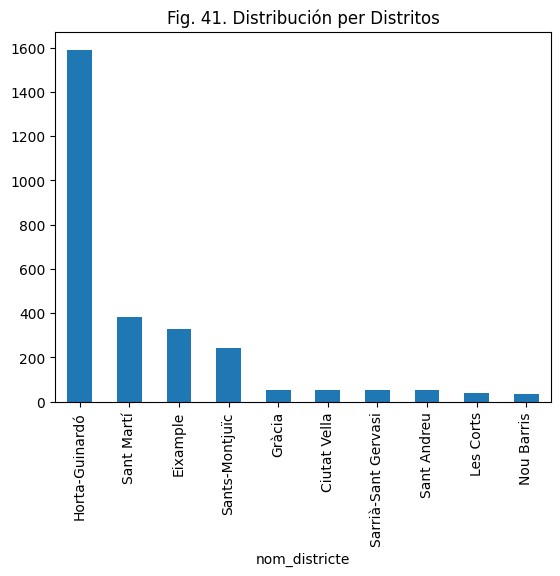

In [17]:
df_location.nom_districte.value_counts().plot.bar(x='nom_districte')

count_fig +=1
plt.title(f"Fig. {count_fig}. Distribución per Distritos")

plt.show()

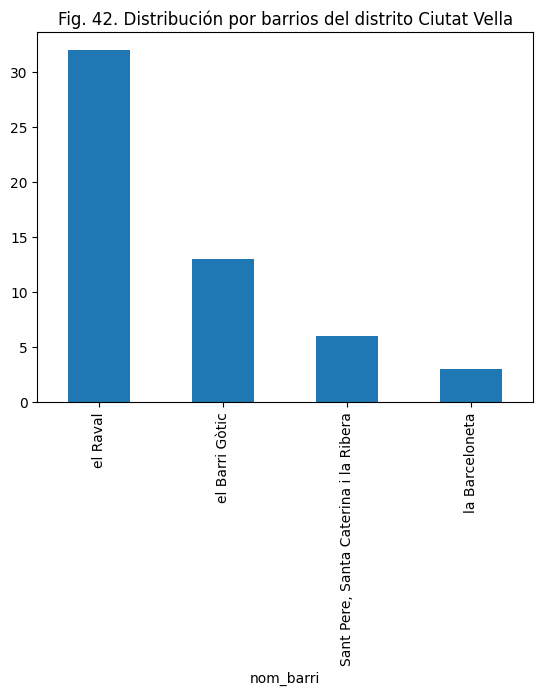

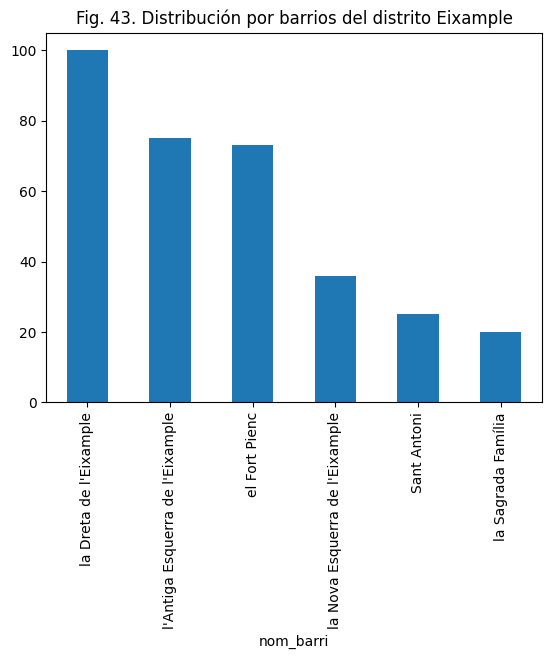

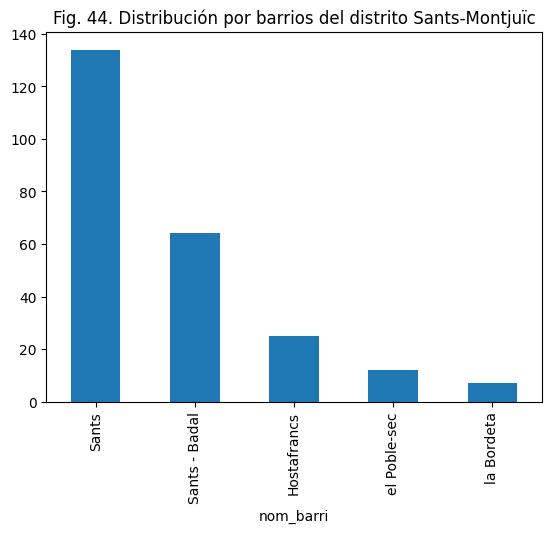

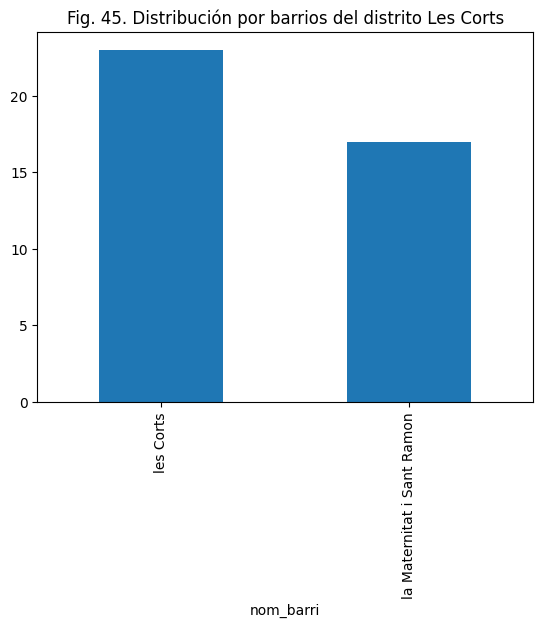

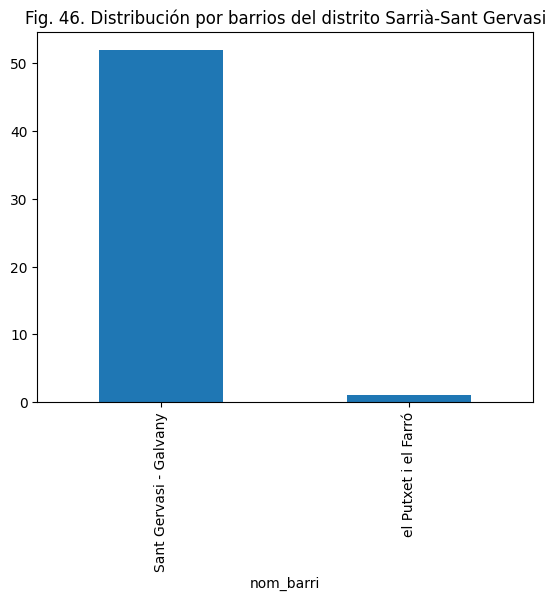

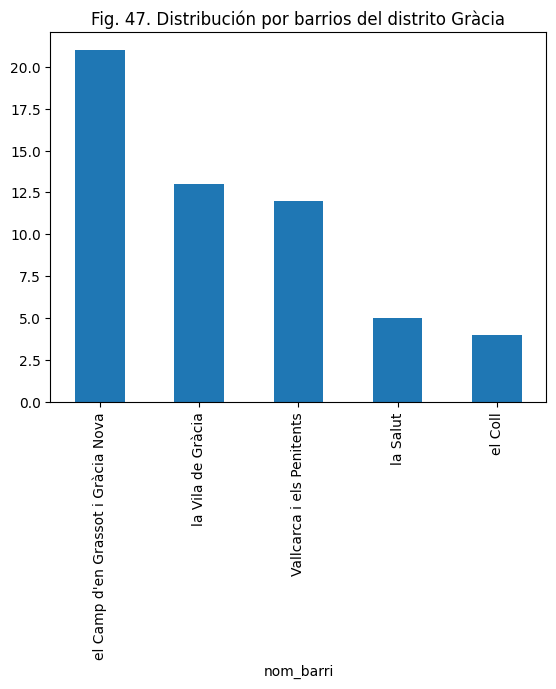

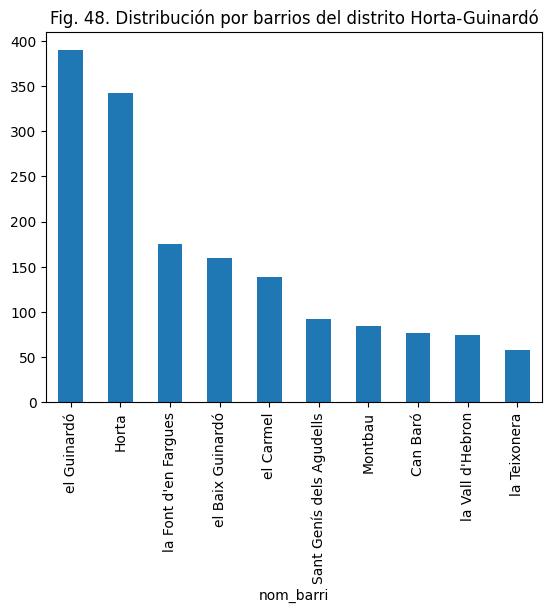

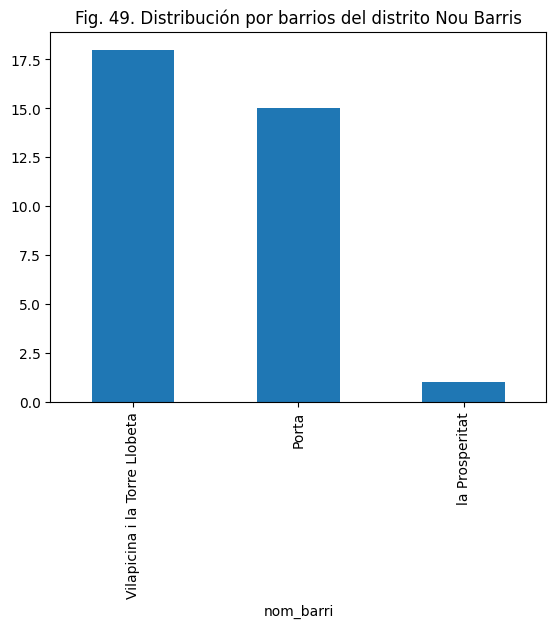

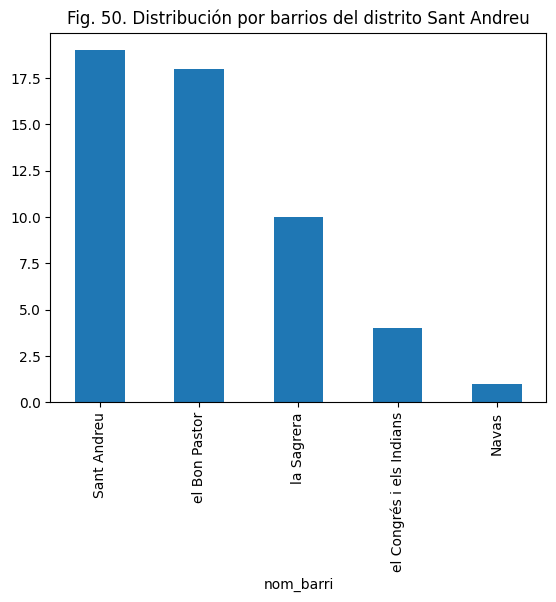

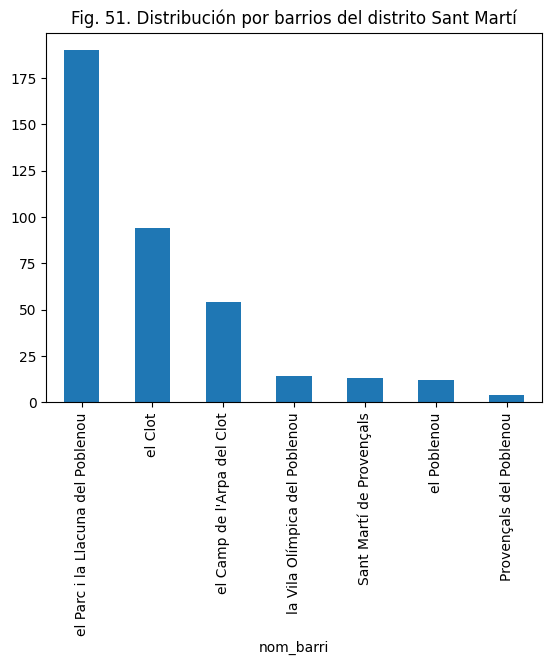

In [18]:
name = dicc_cols_lst[-2]['name']
districtes = dicc_cols_lst[-2]['labels']

for districte in districtes:
    if districte in list(pd.Series(df_location.nom_districte.drop_duplicates())):
        mask = df_location[name] == districte
        df_ = df_location[mask]
            
        barris = dicc_cols_lst[-1]['labels']
        barris_ = list(set(df_.nom_barri))

        labels_result = [l for l in labels if l in labels_]

        df_.nom_barri.value_counts().plot.bar(x='nom_barri')

        count_fig +=1
        plt.title(f"Fig. {count_fig}. Distribución por barrios del distrito {districte}")

        plt.show()

In [19]:
municipis = gpd.read_file("data/geodata/municipis_catalunya.shp")

municipis.to_crs(4326)

# print(municipis.info())

municipis = municipis[['NAMEUNIT', 'geometry']]

municipis.columns = ['nom_municipi', 'geometry']

#municipis.set_geometry('geometria')

print(municipis.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   nom_municipi  948 non-null    object  
 1   geometry      948 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 14.9+ KB
None


In [20]:
#df['municipi'] = "Desconegut"

#for index, row in municipis.iterrows():
#    polygon = row.geometry
#    mask = df['geometry'].apply(polygon.contains)
#    df.loc[mask, 'municipi'] = row.NAMEUNIT
df_location.set_geometry('geometry')
df_location = df_location.drop('index_right', axis=1)
# df_location.info()


In [21]:
df_location_ = gpd.sjoin(df_location, municipis, predicate='within', how='left')
# df_location_.info()

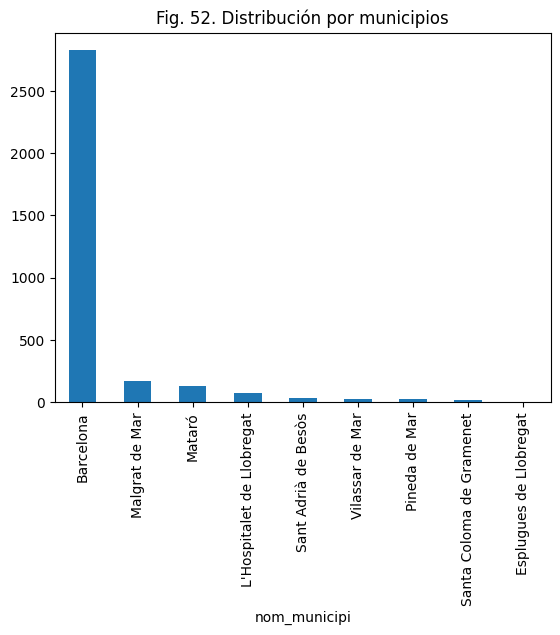

In [22]:
df_location_.nom_municipi.value_counts().plot.bar(x='nom_municipi')

count_fig +=1
plt.title(f"Fig. {count_fig}. Distribución por municipios")

plt.show()

# Preprocesamiento previo al etiquetado de instancias

In [23]:
path_disk = "/home/joan_ds/Sandbox/UOC/TFM/data/solocator"
images_folder_path = Path('/'.join([path_disk, 'photos']))

In [24]:
path_disk = "/home/joan_ds/Sandbox/UOC/TFM/data/solocator"
images_folder_path = Path('/'.join([path_disk, 'photos']))
print(images_folder_path)

images_folder_path.mkdir(parents=True, exist_ok=True)

/home/joan_ds/Sandbox/UOC/TFM/data/solocator/photos


In [25]:
path_hdd = '/media/joan_ds/Seagate Portable Drive/dades/Solocator'

for zips in tqdm(glob('/'.join([path_hdd, '*.zip']))):
    #print(zips)
    with ZipFile(zips) as z_object:
        for file_info in z_object.infolist():
            if file_info.filename.endswith('.jpg'):
                z_object.extract(file_info, images_folder_path)

100%|██████████| 47/47 [02:03<00:00,  2.63s/it]


In [26]:
def metadata_generator_img(image, id: str, label=''):

    size_image = os.path.getsize(image)
    size_image = round((size_image / 1024) / 1024, 3)
    
    with Image.open(image) as img:
            
        width, height = img.size
    
    dicc = {f'id{label}': id, f'path{label}': image,
            f'dims{label}': f"{width}x{height}",
            f'width{label}': width, f'height{label}': height,
            f'size{label}': size_image}

    return dicc

In [27]:
regex_timestamp = r'([0-9]{4}-[0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2}-[0-9]{2})|([0-9]{4}-[0-9]{2}-[0-9]{2};[0-9]{2}-[0-9]{2}-[0-9]{2})'

lst_dicc = []

for dirpath, _, filenames in os.walk(images_folder_path):
                     
    for file in filenames:
        timestamp = re.search(regex_timestamp, file).group(0)
        timestamp = timestamp.replace(";", "-")
        new_file = timestamp + '.jpg'
        os.rename(os.path.join(dirpath, file), os.path.join(dirpath, new_file))

        image = os.path.abspath(os.path.join(dirpath, new_file))
        dicc = metadata_generator_img(image, timestamp)
        lst_dicc.append(dicc)

In [28]:
images_df = pd.DataFrame.from_dict(lst_dicc)

images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3302 non-null   object 
 1   path    3302 non-null   object 
 2   dims    3302 non-null   object 
 3   width   3302 non-null   int64  
 4   height  3302 non-null   int64  
 5   size    3302 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 154.9+ KB


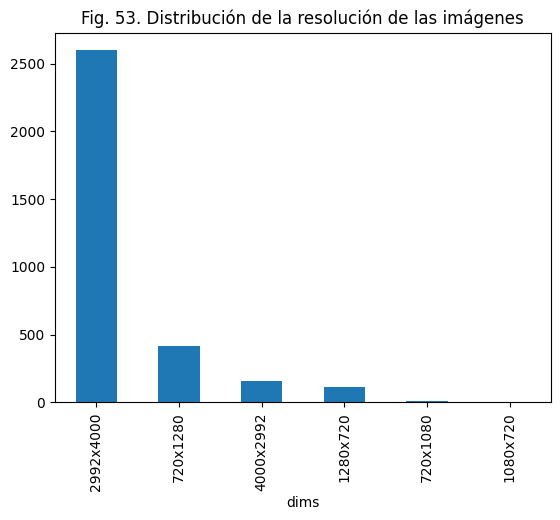

In [29]:
dims_cols = ['dims']

for col in dims_cols:
    images_df[col].value_counts().plot(kind='bar', legend=False)
    count_fig +=1

    plt.title(f"Fig. {count_fig}. Distribución de la resolución de las imágenes")

    plt.show()

## Recorte de los encabezamientos de las imágenes

In [30]:
sample_images = []

for dim in list(set(images_df.dims)):
    print(dim)
    mask = images_df.dims == dim
    df_ = images_df[mask]
    path_image = df_.sample(1)
    sample_images.append(list(path_image.path)[0])

1080x720
720x1280
720x1080
1280x720
2992x4000
4000x2992


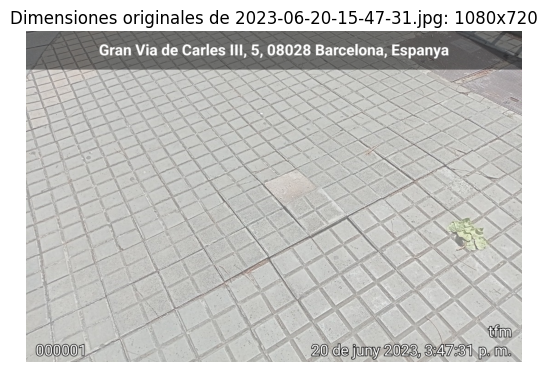

Imagen recortada guardada en /home/joan_ds/Sandbox/UOC/TFM/trials_imgs/


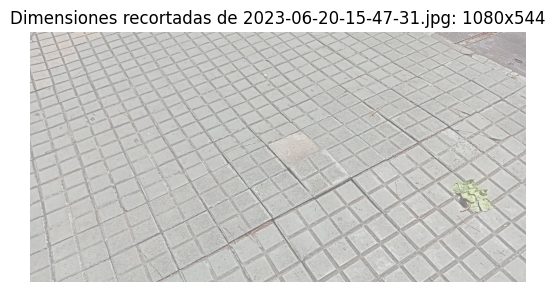

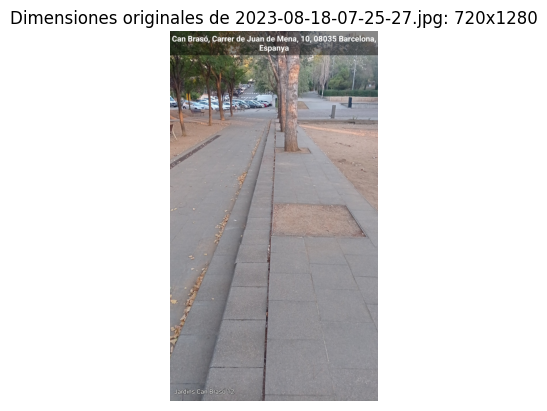

Imagen recortada guardada en /home/joan_ds/Sandbox/UOC/TFM/trials_imgs/


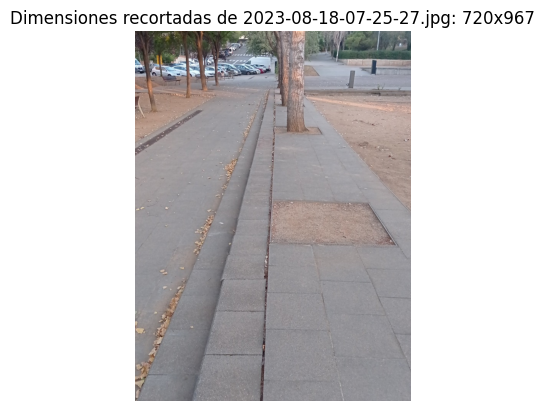

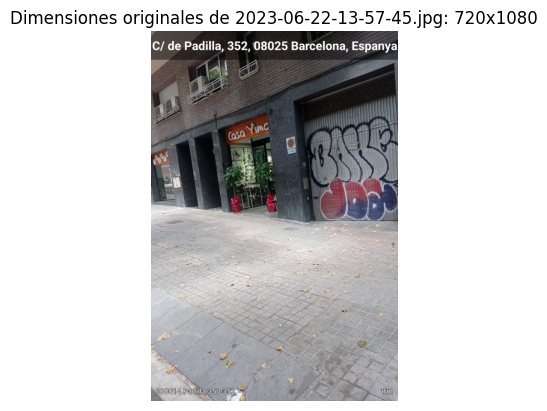

Imagen recortada guardada en /home/joan_ds/Sandbox/UOC/TFM/trials_imgs/


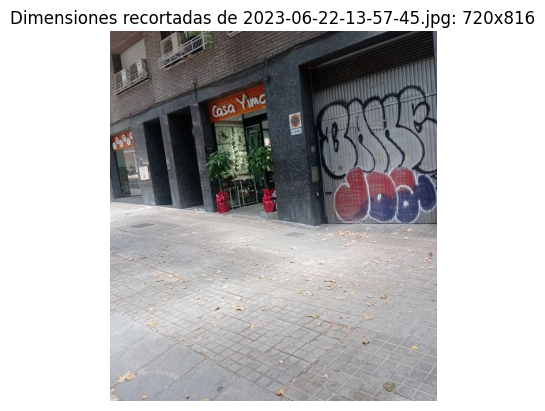

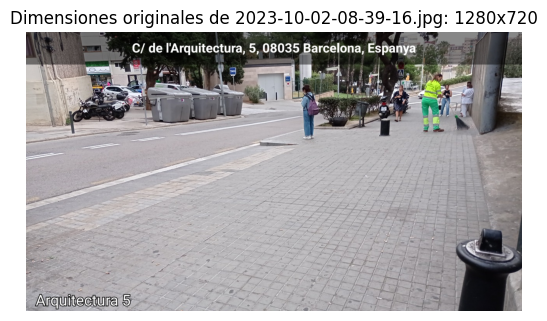

Imagen recortada guardada en /home/joan_ds/Sandbox/UOC/TFM/trials_imgs/


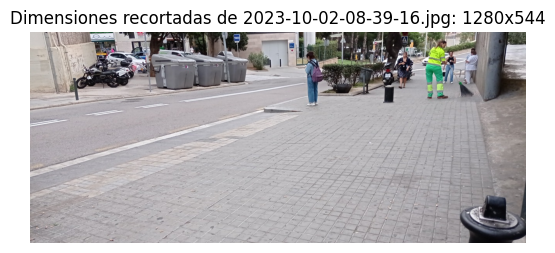

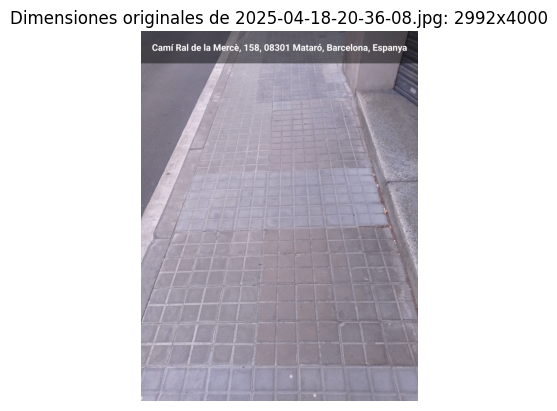

Imagen recortada guardada en /home/joan_ds/Sandbox/UOC/TFM/trials_imgs/


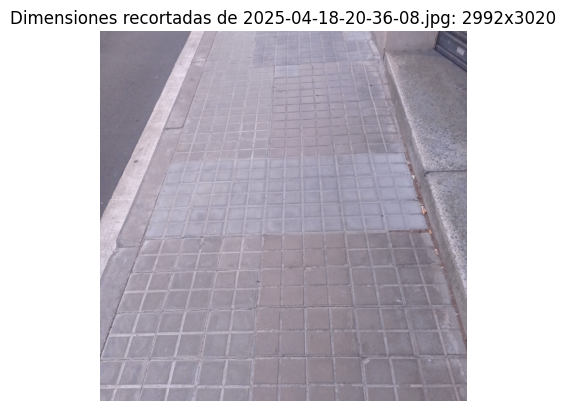

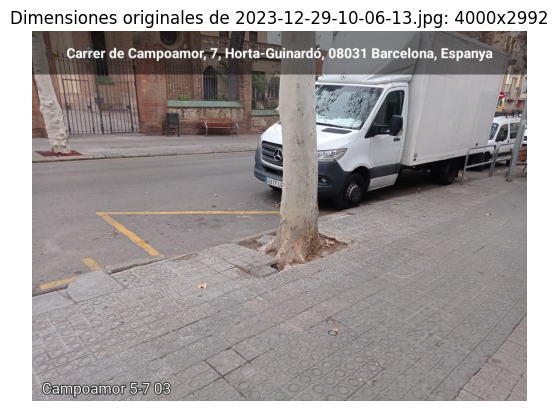

Imagen recortada guardada en /home/joan_ds/Sandbox/UOC/TFM/trials_imgs/


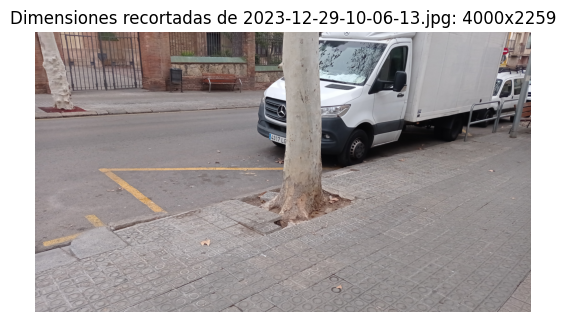

In [31]:
# Ruta on guardar la imatge retallada
output_folder = '/home/joan_ds/Sandbox/UOC/TFM/trials_imgs/'

for input_path in sample_images:

    filename = input_path.rsplit("/")[-1]
    with Image.open(input_path) as img:
        width, height = img.size
        crop_top = int(height * 0.12)     
        crop_bottom = int(height * 0.125)  
    
        # Definim la nova caixa de retall
        left = 0
        top = crop_top
        right = width
        bottom = height - crop_bottom
        img_cropped = img.crop((left, top, right, bottom))
        new_path = output_folder + filename
    
    # Guardem la imatge retallada
        img_cropped.save(new_path)
        plt.imshow(img)
        plt.title(f"Dimensiones originales de {filename}: {width}x{height}")
        plt.axis("off")
        plt.show()

        print(f"Imagen recortada guardada en {output_folder}")
        width, height = img_cropped.size
        plt.imshow(img_cropped)        

        plt.title(f"Dimensiones recortadas de {filename}: {width}x{height}")
        plt.axis("off")
        plt.show()
        

In [32]:
output_folder = '/home/joan_ds/Sandbox/UOC/TFM/data/images/'

for input_path in tqdm(list(images_df.path), desc="Retallant imatges"):

    filename = input_path.rsplit("/")[-1]
    with Image.open(input_path) as img:
        width, height = img.size
        crop_top = int(height * 0.12)     
        crop_bottom = int(height * 0.125)  
    
        # Definim la nova caixa de retall
        left = 0
        top = crop_top
        right = width
        bottom = height - crop_bottom
        img_cropped = img.crop((left, top, right, bottom))
        new_path = output_folder + filename
    
    # Guardem la imatge retallada
        img_cropped.save(new_path)

Retallant imatges: 100%|██████████| 3302/3302 [03:30<00:00, 15.67it/s]


## Distribució del format de les imatges per etiquetar

In [33]:
cropped_folder_path = '/home/joan_ds/Sandbox/UOC/TFM/data/images/'

lst_dicc = []

for dirpath, _, filenames in os.walk(cropped_folder_path):
                     
    for file in filenames:
        timestamp = re.search(regex_timestamp, file).group(0)
        timestamp = timestamp.replace(";", "-")
        new_file = timestamp + '.jpg'
        os.rename(os.path.join(dirpath, file), os.path.join(dirpath, new_file))

        image = os.path.abspath(os.path.join(dirpath, new_file))
        dicc = metadata_generator_img(image, timestamp, label='_cropped')
        lst_dicc.append(dicc)


In [34]:
cropped_df = pd.DataFrame.from_dict(lst_dicc)

cropped_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_cropped      3302 non-null   object 
 1   path_cropped    3302 non-null   object 
 2   dims_cropped    3302 non-null   object 
 3   width_cropped   3302 non-null   int64  
 4   height_cropped  3302 non-null   int64  
 5   size_cropped    3302 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 154.9+ KB


In [35]:
df_images = pd.merge(images_df, cropped_df, how='left', left_on='id', right_on='id_cropped')
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3302 non-null   object 
 1   path            3302 non-null   object 
 2   dims            3302 non-null   object 
 3   width           3302 non-null   int64  
 4   height          3302 non-null   int64  
 5   size            3302 non-null   float64
 6   id_cropped      3302 non-null   object 
 7   path_cropped    3302 non-null   object 
 8   dims_cropped    3302 non-null   object 
 9   width_cropped   3302 non-null   int64  
 10  height_cropped  3302 non-null   int64  
 11  size_cropped    3302 non-null   float64
dtypes: float64(2), int64(4), object(6)
memory usage: 309.7+ KB


In [36]:
df_images = df_images.drop('id_cropped', axis=1)

df_images.head()

id                                               path  \
0  2025-04-17-21-37-14  /home/joan_ds/Sandbox/UOC/TFM/data/solocator/p...   
1  2023-10-27-09-47-26  /home/joan_ds/Sandbox/UOC/TFM/data/solocator/p...   
2  2023-11-19-16-19-32  /home/joan_ds/Sandbox/UOC/TFM/data/solocator/p...   
3  2024-10-19-09-24-44  /home/joan_ds/Sandbox/UOC/TFM/data/solocator/p...   
4  2024-11-16-12-57-04  /home/joan_ds/Sandbox/UOC/TFM/data/solocator/p...   

        dims  width  height   size  \
0  2992x4000   2992    4000  3.441   
1   720x1280    720    1280  0.619   
2   720x1280    720    1280  0.553   
3  2992x4000   2992    4000  7.523   
4  2992x4000   2992    4000  5.288   

                                        path_cropped dims_cropped  \
0  /home/joan_ds/Sandbox/UOC/TFM/data/images/2025...    2992x3020   
1  /home/joan_ds/Sandbox/UOC/TFM/data/images/2023...      720x967   
2  /home/joan_ds/Sandbox/UOC/TFM/data/images/2023...      720x967   
3  /home/joan_ds/Sandbox/UOC/TFM/data/images/2024...    2992x3020   
4  /home/joan_ds/Sandbox/UOC/TFM/data/images/2024...    2992x3020   

   width_cropped  height_cropped  size_cropped  
0           2992            3020         0.297  
1            720             967         0.158  
2            720             967         0.131  
3           2992            3020         1.619  
4           2992            3020         0.950

In [43]:
df_location['id'] = df_location['Date_Time'].dt.strftime('%Y-%m-%d-%H-%M-%S')
len(df_location[df_location['id'].isna() == False])

3302

In [44]:
df_location.id.head()

0    2024-10-19-09-17-50
1    2024-10-19-09-18-24
2    2024-10-19-09-18-38
3    2024-10-19-09-19-33
4    2024-10-19-09-20-07
Name: id, dtype: object

In [45]:
df = pd.merge(df_location, df_images, how='left', on='id')
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll      

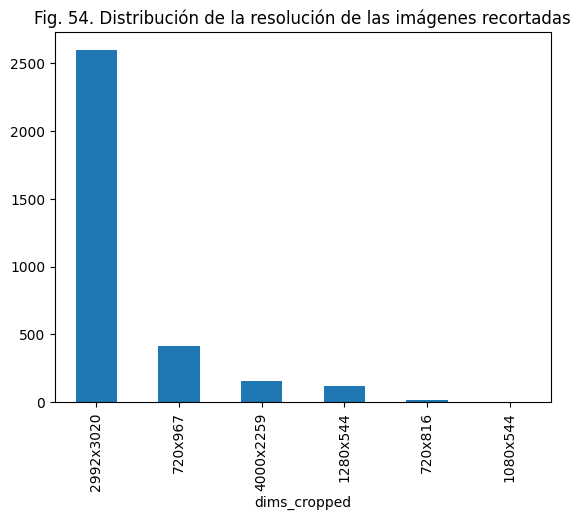

In [46]:
dims_cols = ['dims_cropped']

for col in dims_cols:
    df[col].value_counts().plot(kind='bar', legend=False)
    count_fig +=1

    plt.title(f"Fig. {count_fig}. Distribución de la resolución de las imágenes recortadas")

    plt.show()

In [51]:
now = dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
df_export_filename = f"{now}_biaa_metadata_export.csv"
df.to_csv(df_export_filename, sep=";", index=False)

In [52]:
df_export = pd.read_csv(df_export_filename, sep=";")
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date_Time             3302 non-null   object 
 1   Photo file Name       3302 non-null   object 
 2   Direction             3302 non-null   int64  
 3   Latitude              3302 non-null   float64
 4   Longitude             3302 non-null   float64
 5   Position Accuracy     3302 non-null   object 
 6   Altitude              3302 non-null   object 
 7   Datum                 3302 non-null   object 
 8   Capture Mode Details  3302 non-null   object 
 9   Project Name          29 non-null     object 
 10  Photo Description     2424 non-null   object 
 11  Watermark             0 non-null      float64
 12  Tilt                  3302 non-null   object 
 13  Roll                  3302 non-null   object 
 14  filename_zip          3302 non-null   object 
 15  year                 